In [1]:
from preprocess import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

%load_ext autoreload

%autoreload 2

2022-04-21 21:29:11.554471: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-21 21:29:11.554620: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Convert raw audio to MFCC arrays for training

In [2]:
max_len = 11
buckets = 20

# Save data to array file first
save_data_to_array(max_len=max_len, n_mfcc=buckets)

Saving vectors of label - 'up': 100%|██████████████████████████████████████████████| 2375/2375 [00:13<00:00, 176.16it/s]


## Import Training Data

In [3]:
labels, _, _ = get_labels()
labels

['right', 'down', 'left', 'up']

In [4]:
# Getting first arrays
X = np.load(labels[0] + '.npy')
y = np.zeros(X.shape[0])

# Append all of the dataset into one single array, same goes for y
for i, label in enumerate(labels[1:]):
    x = np.load(label + '.npy')
    X = np.vstack((X, x))
    y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))

In [5]:
X.shape[0] == len(y)

True

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [7]:
X_train.shape,  y_train.shape, X_test.shape, y_test.shape

((6617, 20, 11), (6617,), (2837, 20, 11), (2837,))

# Visualize data

In [8]:
# # Feature dimension
channels = 1

# In order plot mffc as an image, we need to reshape the data so we can plot the channel value.
X_train = X_train.reshape(X_train.shape[0], buckets, max_len, channels)
X_test = X_test.reshape(X_test.shape[0], buckets, max_len, channels)

In [9]:
X_train.shape,  y_train.shape, X_test.shape, y_test.shape

((6617, 20, 11, 1), (6617,), (2837, 20, 11, 1), (2837,))

0.0


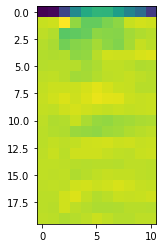

In [10]:
plt.imshow(X_train[100, :, :, 0])
print(y_train[100])

## ANN model 

In [11]:
# one hot encode our targets for multiclass classification
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

In [12]:
# reshape the data back to one MFCC array per observation
X_train = X_train.reshape(X_train.shape[0], buckets, max_len)
X_test = X_test.reshape(X_test.shape[0], buckets, max_len)

In [13]:
X_train.shape,  y_train.shape, X_test.shape, y_test.shape

((6617, 20, 11), (6617,), (2837, 20, 11), (2837,))

In [14]:
epochs = 500
batch_size = 32
num_classes = 4

# Build model
model = Sequential()
model.add(Flatten(input_shape=(buckets, max_len)))
model.add(Dense(25,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

2022-04-21 21:30:06.639181: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-21 21:30:06.639338: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-21 21:30:06.639415: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-3L661AJ): /proc/driver/nvidia/version does not exist
2022-04-21 21:30:06.640622: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
# Compile model
model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 220)               0         
                                                                 
 dense (Dense)               (None, 25)                5525      
                                                                 
 dense_1 (Dense)             (None, 10)                260       
                                                                 
 dense_2 (Dense)             (None, 4)                 44        
                                                                 
Total params: 5,829
Trainable params: 5,829
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Train our model
es = EarlyStopping(patience=30, restore_best_weights=True)

history = model.fit(X_train, y_train_hot, 
                    validation_split=0.3, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=1, 
                    callbacks=[es])

Epoch 1/500
145/145 [==============================] - 1s 3ms/step - loss: 5.2705 - accuracy: 0.2693 - val_loss: 1.4418 - val_accuracy: 0.2704
Epoch 2/500
145/145 [==============================] - 0s 2ms/step - loss: 1.4212 - accuracy: 0.2609 - val_loss: 1.4102 - val_accuracy: 0.2669
Epoch 3/500
145/145 [==============================] - 0s 3ms/step - loss: 1.3735 - accuracy: 0.2738 - val_loss: 1.3985 - val_accuracy: 0.2895
Epoch 4/500
145/145 [==============================] - 0s 2ms/step - loss: 1.3544 - accuracy: 0.2906 - val_loss: 1.3786 - val_accuracy: 0.3343
Epoch 5/500
145/145 [==============================] - 0s 2ms/step - loss: 1.3152 - accuracy: 0.3431 - val_loss: 1.3412 - val_accuracy: 0.3711
Epoch 6/500
145/145 [==============================] - 0s 2ms/step - loss: 1.2832 - accuracy: 0.3684 - val_loss: 1.3158 - val_accuracy: 0.3953
Epoch 7/500
145/145 [==============================] - 0s 2ms/step - loss: 1.2443 - accuracy: 0.3924 - val_loss: 1.2950 - val_accuracy: 0.4058

Epoch 58/500
145/145 [==============================] - 0s 2ms/step - loss: 0.2411 - accuracy: 0.8942 - val_loss: 0.7521 - val_accuracy: 0.8097
Epoch 59/500
145/145 [==============================] - 0s 2ms/step - loss: 0.2655 - accuracy: 0.8890 - val_loss: 0.8384 - val_accuracy: 0.7991
Epoch 60/500
145/145 [==============================] - 0s 2ms/step - loss: 0.2549 - accuracy: 0.8888 - val_loss: 0.8659 - val_accuracy: 0.7910
Epoch 61/500
145/145 [==============================] - 0s 2ms/step - loss: 0.2419 - accuracy: 0.8964 - val_loss: 0.8655 - val_accuracy: 0.7986
Epoch 62/500
145/145 [==============================] - 0s 2ms/step - loss: 0.2408 - accuracy: 0.8970 - val_loss: 0.8413 - val_accuracy: 0.8051
Epoch 63/500
145/145 [==============================] - 0s 2ms/step - loss: 0.2281 - accuracy: 0.9035 - val_loss: 0.8435 - val_accuracy: 0.8016
Epoch 64/500
145/145 [==============================] - 0s 2ms/step - loss: 0.2319 - accuracy: 0.9026 - val_loss: 0.8399 - val_accuracy:

In [18]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'])
    plt.title('Train loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

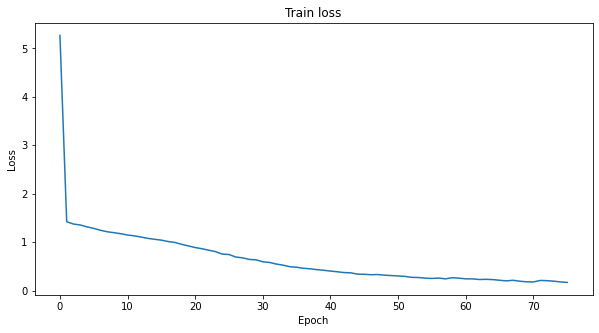

In [19]:
plot_history(history)

In [20]:
def plot_loss_accuracy(history):
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

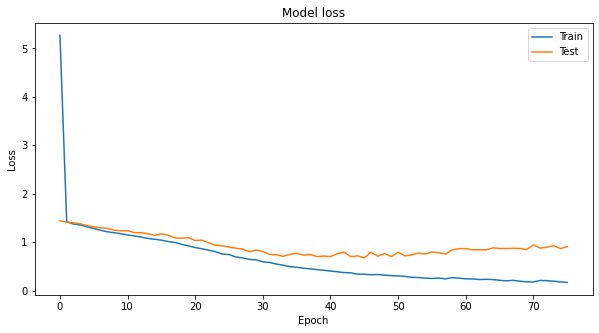

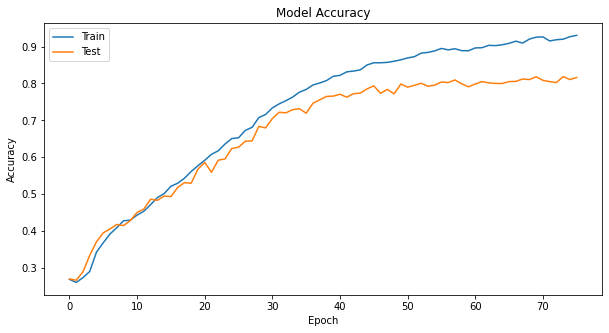

In [21]:
plot_loss_accuracy(history)

## CNN Model

In [22]:
# expand dimensions, so that the last dimension is the number of channels.
# this is required for CNN.
X_train = X_train.reshape(X_train.shape[0], buckets, max_len, channels)
X_test = X_test.reshape(X_test.shape[0], buckets, max_len, channels)

In [23]:
X_train.shape,  y_train.shape, X_test.shape, y_test.shape

((6617, 20, 11, 1), (6617,), (2837, 20, 11, 1), (2837,))

### CNN with 1 CONV2D layer, 1 Maxpool layer

In [24]:
# build model
CNN_model_1 = Sequential()
CNN_model_1.add(Conv2D(32,
    (3,3),
    input_shape=(buckets,max_len,channels),
    activation='relu'))
CNN_model_1.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model_1.add(Flatten())
CNN_model_1.add(Dense(128, activation='relu'))
CNN_model_1.add(Dense(num_classes, activation='softmax'))

#Compile
CNN_model_1.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])



In [25]:
CNN_model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 9, 32)         320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 4, 32)         0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 1152)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               147584    
                                                                 
 dense_4 (Dense)             (None, 4)                 516       
                                                                 
Total params: 148,420
Trainable params: 148,420
Non-trainable params: 0
________________________________________________

In [26]:
# Train our model
es = EarlyStopping(patience=30, restore_best_weights=True)

CNN_model_1_history = CNN_model_1.fit(X_train, y_train_hot, 
                    validation_split=0.3, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=1, 
                    callbacks=[es])

Epoch 1/500
145/145 [==============================] - 1s 6ms/step - loss: 1.9972 - accuracy: 0.5368 - val_loss: 0.8975 - val_accuracy: 0.6752
Epoch 2/500
145/145 [==============================] - 1s 6ms/step - loss: 0.6381 - accuracy: 0.7603 - val_loss: 0.6245 - val_accuracy: 0.7749
Epoch 3/500
145/145 [==============================] - 1s 4ms/step - loss: 0.4645 - accuracy: 0.8290 - val_loss: 0.5086 - val_accuracy: 0.8102
Epoch 4/500
145/145 [==============================] - 1s 4ms/step - loss: 0.3901 - accuracy: 0.8549 - val_loss: 0.5072 - val_accuracy: 0.8273
Epoch 5/500
145/145 [==============================] - 1s 4ms/step - loss: 0.2804 - accuracy: 0.8994 - val_loss: 0.3849 - val_accuracy: 0.8666
Epoch 6/500
145/145 [==============================] - 1s 4ms/step - loss: 0.2416 - accuracy: 0.9141 - val_loss: 0.4285 - val_accuracy: 0.8494
Epoch 7/500
145/145 [==============================] - 1s 4ms/step - loss: 0.2071 - accuracy: 0.9249 - val_loss: 0.3578 - val_accuracy: 0.8766

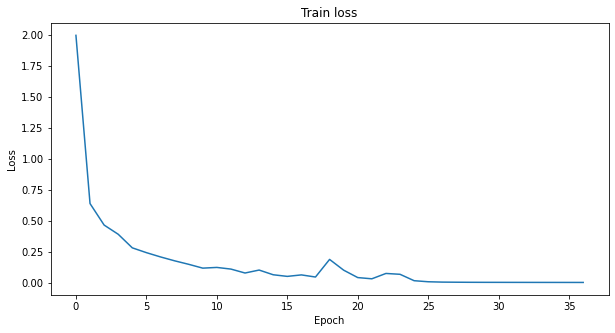

In [27]:
plot_history(CNN_model_1_history)

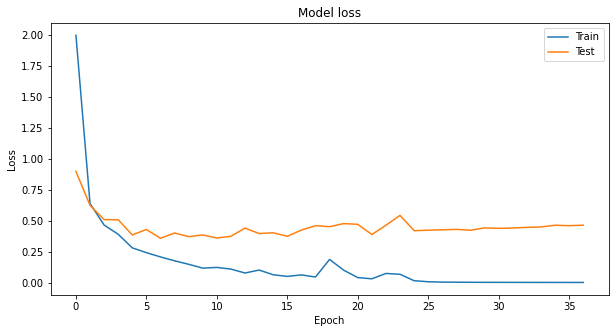

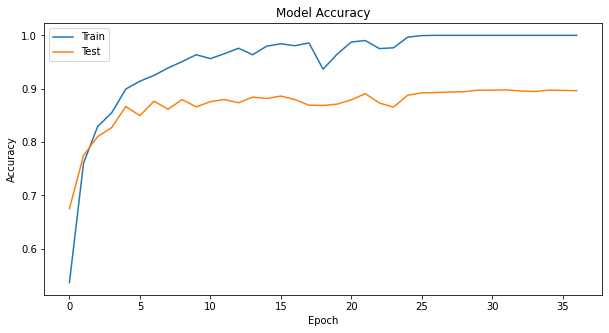

In [28]:
plot_loss_accuracy(CNN_model_1_history)

### CNN with 2 CONV2D layers, 2 Maxpool layers


In [29]:
# build model
CNN_model_2 = Sequential()
CNN_model_2.add(Conv2D(32,
    (3,3),
    input_shape=(buckets,max_len,channels),
    activation='relu'))
CNN_model_2.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model_2.add(Conv2D(32,
    (3,3),
    input_shape=(buckets,max_len,channels),
    activation='relu'))
CNN_model_2.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model_2.add(Flatten())
CNN_model_2.add(Dense(128, activation='relu'))
CNN_model_2.add(Dense(num_classes, activation='softmax'))

#Compile
CNN_model_2.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])


In [30]:
CNN_model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 18, 9, 32)         320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 4, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 2, 32)          9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 1, 32)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 96)                0         
                                                                 
 dense_5 (Dense)             (None, 128)              

In [31]:
# Train our model
es = EarlyStopping(patience=30, restore_best_weights=True)

CNN_model_2_history = CNN_model_2.fit(X_train, y_train_hot, 
                    validation_split=0.3, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=1, 
                    callbacks=[es])

Epoch 1/500
145/145 [==============================] - 1s 6ms/step - loss: 1.3371 - accuracy: 0.5282 - val_loss: 0.8662 - val_accuracy: 0.6767
Epoch 2/500
145/145 [==============================] - 1s 6ms/step - loss: 0.5990 - accuracy: 0.7635 - val_loss: 0.5729 - val_accuracy: 0.7779
Epoch 3/500
145/145 [==============================] - 1s 5ms/step - loss: 0.4625 - accuracy: 0.8273 - val_loss: 0.4449 - val_accuracy: 0.8338
Epoch 4/500
145/145 [==============================] - 1s 4ms/step - loss: 0.3666 - accuracy: 0.8646 - val_loss: 0.4744 - val_accuracy: 0.8243
Epoch 5/500
145/145 [==============================] - 1s 4ms/step - loss: 0.3100 - accuracy: 0.8812 - val_loss: 0.3963 - val_accuracy: 0.8585
Epoch 6/500
145/145 [==============================] - 1s 4ms/step - loss: 0.2672 - accuracy: 0.8992 - val_loss: 0.3922 - val_accuracy: 0.8595
Epoch 7/500
145/145 [==============================] - 1s 5ms/step - loss: 0.2140 - accuracy: 0.9175 - val_loss: 0.3423 - val_accuracy: 0.8807

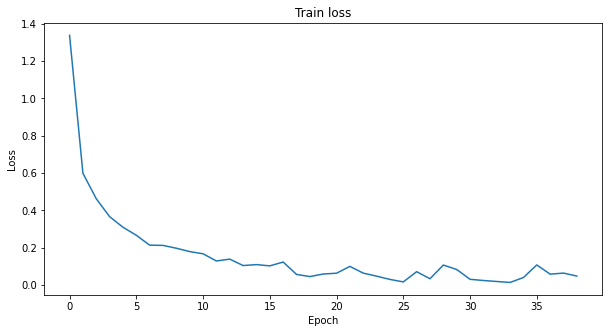

In [32]:
plot_history(CNN_model_2_history)

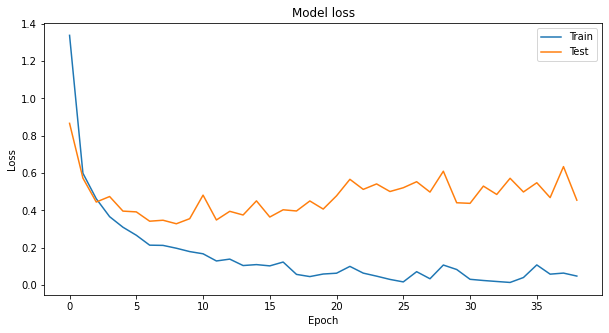

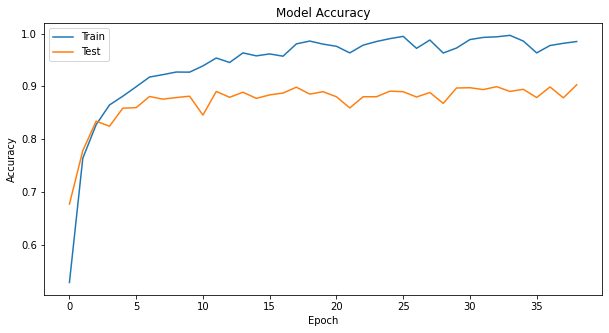

In [33]:
plot_loss_accuracy(CNN_model_2_history)

### CNN with 2 CONV2D layers, 2 Maxpool layers, 2 Dropout Layers

Both the 1 and 2 CONV2D layer models exhibit over-fitting. applying dropout layers to reduce variance

In [34]:
# build model
CNN_model_3 = Sequential()
CNN_model_3.add(Conv2D(32,
    (3,3),
    input_shape=(buckets,max_len,channels),
    activation='relu'))
CNN_model_3.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model_3.add(Dropout(0.25))
CNN_model_3.add(Conv2D(32,
    (3,3),
    input_shape=(buckets,max_len,channels),
    activation='relu'))
CNN_model_3.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model_3.add(Dropout(0.25))
CNN_model_3.add(Flatten())
CNN_model_3.add(Dense(128, activation='relu'))
CNN_model_3.add(Dense(num_classes, activation='softmax'))

#Compile
CNN_model_3.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])

In [35]:
CNN_model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 18, 9, 32)         320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 9, 4, 32)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 9, 4, 32)          0         
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 2, 32)          9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 3, 1, 32)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 3, 1, 32)         

In [36]:
# Train our model
es = EarlyStopping(patience=30, restore_best_weights=True)

CNN_model_3_history = CNN_model_3.fit(X_train, y_train_hot, 
                    validation_split=0.3, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=1, 
                    callbacks=[es])

Epoch 1/500
145/145 [==============================] - 1s 7ms/step - loss: 2.0882 - accuracy: 0.3014 - val_loss: 1.3294 - val_accuracy: 0.3716
Epoch 2/500
145/145 [==============================] - 1s 6ms/step - loss: 1.3232 - accuracy: 0.3602 - val_loss: 1.2391 - val_accuracy: 0.4290
Epoch 3/500
145/145 [==============================] - 1s 5ms/step - loss: 1.2429 - accuracy: 0.4090 - val_loss: 1.0882 - val_accuracy: 0.5156
Epoch 4/500
145/145 [==============================] - 1s 5ms/step - loss: 1.1500 - accuracy: 0.4727 - val_loss: 1.0098 - val_accuracy: 0.5806
Epoch 5/500
145/145 [==============================] - 1s 5ms/step - loss: 1.0794 - accuracy: 0.5176 - val_loss: 0.9238 - val_accuracy: 0.6440
Epoch 6/500
145/145 [==============================] - 1s 6ms/step - loss: 0.9611 - accuracy: 0.5785 - val_loss: 0.7193 - val_accuracy: 0.7356
Epoch 7/500
145/145 [==============================] - 1s 6ms/step - loss: 0.8860 - accuracy: 0.6184 - val_loss: 0.6611 - val_accuracy: 0.7518

Epoch 58/500
145/145 [==============================] - 1s 7ms/step - loss: 0.3106 - accuracy: 0.8836 - val_loss: 0.2896 - val_accuracy: 0.8958
Epoch 59/500
145/145 [==============================] - 1s 7ms/step - loss: 0.3109 - accuracy: 0.8877 - val_loss: 0.2813 - val_accuracy: 0.8973
Epoch 60/500
145/145 [==============================] - 1s 7ms/step - loss: 0.3182 - accuracy: 0.8799 - val_loss: 0.2721 - val_accuracy: 0.9013
Epoch 61/500
145/145 [==============================] - 1s 7ms/step - loss: 0.3081 - accuracy: 0.8825 - val_loss: 0.2782 - val_accuracy: 0.8912
Epoch 62/500
145/145 [==============================] - 1s 7ms/step - loss: 0.3020 - accuracy: 0.8838 - val_loss: 0.2586 - val_accuracy: 0.9013
Epoch 63/500
145/145 [==============================] - 1s 7ms/step - loss: 0.3174 - accuracy: 0.8819 - val_loss: 0.2806 - val_accuracy: 0.8993
Epoch 64/500
145/145 [==============================] - 1s 7ms/step - loss: 0.3158 - accuracy: 0.8799 - val_loss: 0.2732 - val_accuracy:

145/145 [==============================] - 1s 9ms/step - loss: 0.2541 - accuracy: 0.9102 - val_loss: 0.2514 - val_accuracy: 0.9099
Epoch 115/500
145/145 [==============================] - 1s 9ms/step - loss: 0.2246 - accuracy: 0.9177 - val_loss: 0.2644 - val_accuracy: 0.9038
Epoch 116/500
145/145 [==============================] - 1s 9ms/step - loss: 0.2350 - accuracy: 0.9106 - val_loss: 0.2810 - val_accuracy: 0.9013
Epoch 117/500
145/145 [==============================] - 1s 8ms/step - loss: 0.2526 - accuracy: 0.9093 - val_loss: 0.2517 - val_accuracy: 0.9154
Epoch 118/500
145/145 [==============================] - 1s 8ms/step - loss: 0.2414 - accuracy: 0.9143 - val_loss: 0.2588 - val_accuracy: 0.9124
Epoch 119/500
145/145 [==============================] - 1s 7ms/step - loss: 0.2350 - accuracy: 0.9147 - val_loss: 0.2644 - val_accuracy: 0.9053
Epoch 120/500
145/145 [==============================] - 1s 8ms/step - loss: 0.2366 - accuracy: 0.9091 - val_loss: 0.2488 - val_accuracy: 0.9099

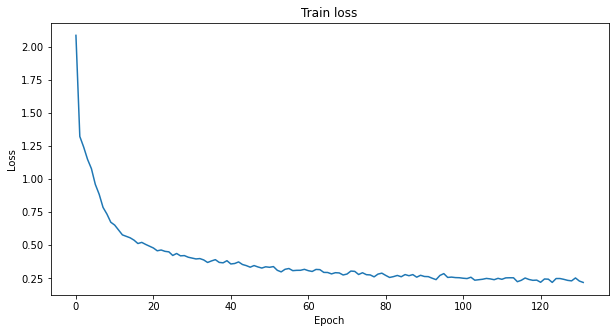

In [37]:
plot_history(CNN_model_3_history)

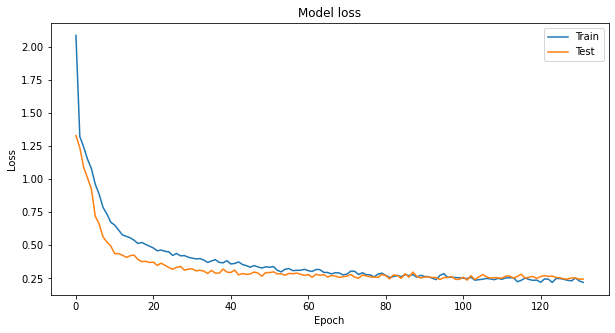

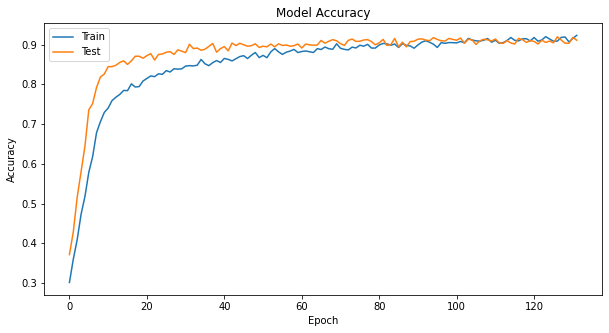

In [38]:
plot_loss_accuracy(CNN_model_3_history)